# **Importing Libraries**

In [1]:
# Import the needed Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

# Supress all the warnings
import warnings
warnings.filterwarnings('ignore')

# Import the random seed and tensorflow
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout, SimpleRNN, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers


# **Loading the Data**

> In this process, this where we learn what's the dataset in consists of as well forming it into dimensions. 

In [2]:
project_folder=r'C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset'
read = pd.read_csv(r"C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\train.csv", dtype=object)
print(read.shape)
print(read.info())

(662, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 1 columns):
 #   Column                                                     Non-Null Count  Dtype 
---  ------                                                     --------------  ----- 
 0   WIN_20180925_17_08_43_Pro_Left_Swipe_new;Left_Swipe_new;0  662 non-null    object
dtypes: object(1)
memory usage: 5.3+ KB
None


# **Generator**

> For train_doc and val_doc, it takes random lists of files in train.csv and val.csv to for when training CNN+RNN model. 

In [3]:
## Let us take the Input in to Train and Val doc and Iniatise the Bath size as 10 first and then we train the model
train_doc = np.random.permutation(open(r"C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\train.csv").readlines())
val_doc = np.random.permutation(open(r"C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\val.csv").readlines())
batch_size = 10 #experiment with the batch size

> In this generator function below,there's  a dataset full of videos. The goal is to try to feed the batches of images from videos. What the function is essentially trying to do is ,from each video , to take x amount of images. For each images, they will be resize to the the number we initialize y and z. Then the images are stored inside the batch size (file). From this batch, each images are double checked if each one of them are in the same dimensions. If not, neural network will consider as an input error. If the two images are in different dimensions, the function will crop and resize the images. Once the whole process is done, the images are stored in another file to use for training the model. 

In [4]:
# Let we do the generators and input the images as we see that our images have two different sizes. 

channels = 3 # RGB as 3D Convlution
clases = 5
x = 30 # No. of frames images
y = 120 # Width of the image
z = 120  # height

def generator_1(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,clases)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Let us resize all the images 
                    Temp_img = resize(image,(y,z)) 
                    Temp_img = Temp_img.mean(axis=-1,keepdims=1)  # Let us convert to the Grey scale
                    Temp_img = Temp_img/127.5-1 
                    
                    batch_data[folder,idx] = Temp_img #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

 # write the code for the remaining data points which are left after full batches.
        
# Let us see that if the folder is not equal to the batch size * num of batches
        
        if (len(folder_list) != batch_size*num_batches):
            print("Batches: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,clases)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    Temp_img = resize(image,(y,z))
                    Temp_img = Temp_img.mean(axis=-1,keepdims=1)  # Let us convert to the Grey scale 
                    Temp_img = Temp_img/127.5-1 #Normalize data
                    
                    batch_data[folder,idx] = Temp_img
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


> This function below is try to count how many videos are currently in train.csv and how many are in in val.csv. 

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = r"C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\Train"
val_path = r"C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\Val"
num_train_sequences = len(train_doc)
print('# Training_Sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation_Sequences =', num_val_sequences)
num_epochs = 40 # choose the number of epochs
print ('# Epochs = ', num_epochs)

# Training_Sequences = 663
# Validation_Sequences = 100
# Epochs =  40


# **Building CNN+RNN Model**

In [6]:


CNNRNN_Model = Sequential()   

CNNRNN_Model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(x,y,z,3)))
CNNRNN_Model.add(TimeDistributed(BatchNormalization()))
CNNRNN_Model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
CNNRNN_Model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
CNNRNN_Model.add(TimeDistributed(BatchNormalization()))
CNNRNN_Model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
CNNRNN_Model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
CNNRNN_Model.add(TimeDistributed(BatchNormalization()))
CNNRNN_Model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
CNNRNN_Model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
CNNRNN_Model.add(TimeDistributed(BatchNormalization()))
CNNRNN_Model.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flatten layer 

CNNRNN_Model.add(TimeDistributed(Flatten()))
CNNRNN_Model.add(SimpleRNN(64))
CNNRNN_Model.add(Dropout(0.25))

# Dense layer 
CNNRNN_Model.add(Dense(64,activation='relu'))
CNNRNN_Model.add(Dropout(0.25))
# Softmax layer

CNNRNN_Model.add(Dense(5, activation='softmax'))

# Adam optimiser

optimiser = optimizers.Adam(lr=0.01) #write your optimizer
CNNRNN_Model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNRNN_Model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 30, 120, 120, 16   448       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 30, 120, 120, 16   64        
 stributed)                  )                                   
                                                                 
 time_distributed_2 (TimeDi  (None, 30, 60, 60, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 30, 60, 60, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 30, 60, 60, 32)    1

In [7]:
# Let us train and validate the model 
train_generator = generator_1(train_path, train_doc, batch_size)
val_generator = generator_1(val_path, val_doc, batch_size)

In [8]:
# Let us see the Validate the Losses and put back the checkpoint

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [9]:
# Let us see that the steps_per_epoch and validation steps are used by fit to decide the no. of next()

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [10]:
history = CNNRNN_Model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=40, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\Train ; batch size = 10


Epoch 1/40



67/67 [==============================] - ETA: 0s - loss: 1.5919 - categorical_accuracy: 0.3243Source path =  C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\Val ; batch size = 10

Epoch 1: saving model to model_init_2024-01-2720_32_20.283659\model-00001-1.59186-0.32428-1.75243-0.25000.h5
67/67 [==============================] - 147s 2s/step - loss: 1.5919 - categorical_accuracy: 0.3243 - val_loss: 1.7524 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/40
67/67 [==============================] - ETA: 0s - loss: 1.5885 - categorical_accuracy: 0.3234
Epoch 2: saving model to model_init_2024-01-2720_32_20.283659\model-00002-1.58846-0.32338-2.12196-0.27000.h5
67/67 [==============================] - 56s 852ms/step - loss: 1.5885 - categorical_accuracy: 0.3234 - val_loss: 2.1220 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/40
67/67 [==============================] - ETA: 0s - loss: 1.5954 - categorical_accuracy: 0.3035
Epoch 3: saving model to model_init_2024-01-2720_32_

In [56]:
from tensorflow.keras.models import load_model

# Specify the complete file path including the filename
model_path = r"C:\Users\Rahul\Desktop\MODELS\CNNRNN_Model1.h5"

# Save the model
CNNRNN_Model.save(model_path)

In [12]:
#tf.keras.models.load_model(model_name)

In [13]:
val_accuracy = np.mean(history.history['val_categorical_accuracy'])
print("\n%s: %.2f%%" % ('Validation Accuracy', val_accuracy*100))


Validation Accuracy: 56.97%


# **Training And Validation Loss Over Epochs**

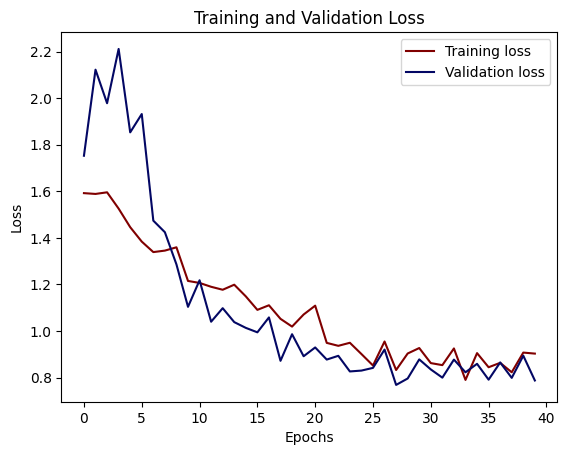

In [14]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)
plt.plot(history_df.loc[:, ['loss']], "#800000", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#030764", label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc="best")
plt.show()


# **Training And Validation Accuracy Over Epochs**

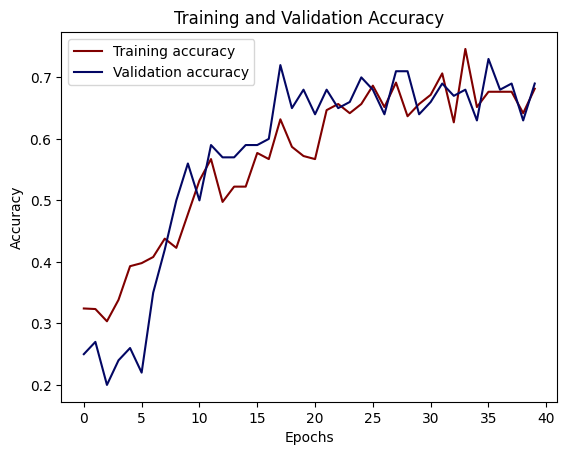

In [15]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['categorical_accuracy']], "#800000", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_categorical_accuracy']], "#030764", label='Validation accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

# **Same CNN+RNN Model with Different Image's Size (30X30)**

In [16]:
x = 30 # number of frames
y = 30 # image width
z = 30 # image height

CNNRNN_Model2 = Sequential()   

CNNRNN_Model2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(x,y,z,3)))
CNNRNN_Model2.add(TimeDistributed(BatchNormalization()))
CNNRNN_Model2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
CNNRNN_Model2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
CNNRNN_Model2.add(TimeDistributed(BatchNormalization()))
CNNRNN_Model2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
CNNRNN_Model2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
CNNRNN_Model2.add(TimeDistributed(BatchNormalization()))
CNNRNN_Model2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
CNNRNN_Model2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
CNNRNN_Model2.add(TimeDistributed(BatchNormalization()))
CNNRNN_Model2.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flatten layer 

CNNRNN_Model2.add(TimeDistributed(Flatten()))

CNNRNN_Model2.add(SimpleRNN(64))
CNNRNN_Model2.add(Dropout(0.25))

# Dense layer 
CNNRNN_Model2.add(Dense(64,activation='relu'))
CNNRNN_Model2.add(Dropout(0.25))
# Softmax layer

CNNRNN_Model2.add(Dense(5, activation='softmax'))

# Adam optimiser

optimiser = optimizers.Adam(lr=0.01) #write your optimizer
CNNRNN_Model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNRNN_Model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeD  (None, 30, 30, 30, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, 30, 30, 30, 16)    64        
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 30, 15, 15, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, 30, 15, 15, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, 30, 15, 15, 32)   

In [17]:
train_generator = generator_1(train_path, train_doc, batch_size)
val_generator = generator_1(val_path, val_doc, batch_size)

In [18]:
history1 = CNNRNN_Model2.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=40, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\Train ; batch size = 10
Epoch 1/40
67/67 [==============================] - ETA: 0s - loss: 1.6235 - categorical_accuracy: 0.3137Source path =  C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\Val ; batch size = 10

Epoch 1: saving model to model_init_2024-01-2720_32_20.283659\model-00001-1.62354-0.31373-1.73755-0.21000.h5
67/67 [==============================] - 136s 2s/step - loss: 1.6235 - categorical_accuracy: 0.3137 - val_loss: 1.7375 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/40
67/67 [==============================] - ETA: 0s - loss: 1.5492 - categorical_accuracy: 0.3134
Epoch 2: saving model to model_init_2024-01-2720_32_20.283659\model-00002-1.54916-0.31343-2.05617-0.30000.h5
67/67 [==============================] - 51s 772ms/step - loss: 1.5492 - categorical_accuracy: 0.3134 - val_loss: 2.0562 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/40
67/67 [==============================] - ETA: 0

In [19]:
val_accuracy = np.mean(history1.history['val_categorical_accuracy'])
print("\n%s: %.2f%%" % ('Validation Accuracy', val_accuracy*100))


Validation Accuracy: 52.15%


# **Training And Validation Loss Over Epochs (Image's Size 30X30)**

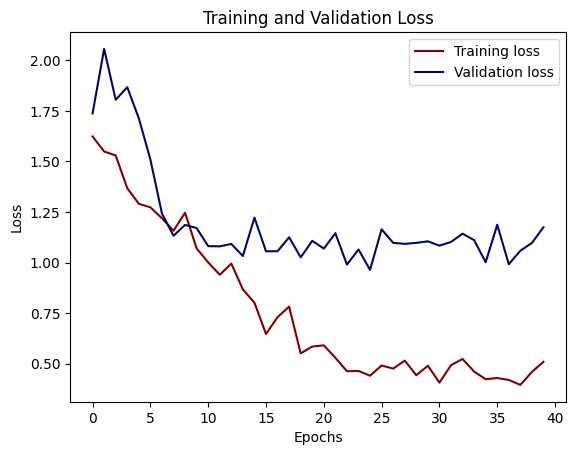

In [20]:
history_df = pd.DataFrame(history1.history)
plt.plot(history_df.loc[:, ['loss']], "#800000", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#030764", label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc="best")
plt.show()

# **Training And Validation Accuracy Over Epochs (Image's Size 30X30)**

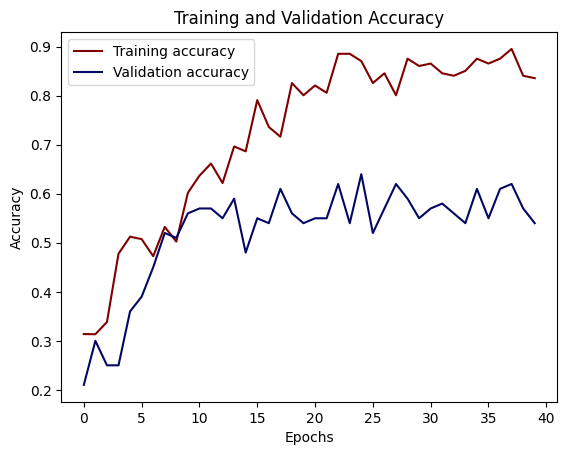

In [21]:
history_df = pd.DataFrame(history1.history)

plt.plot(history_df.loc[:, ['categorical_accuracy']], "#800000", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_categorical_accuracy']], "#030764", label='Validation accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [29]:
from tensorflow.keras.models import load_model

# Specify the complete file path including the filename
model_path = r"C:\Users\Rahul\Desktop\MODELS\CNNRNN_Model2.h5"

# Save the model
CNNRNN_Model2.save(model_path)


In [23]:
#tf.keras.models.load_model(model_name1)

In [43]:
from PIL import Image
import numpy as np
from skimage.transform import resize

# Load the image using PIL
image = Image.open(r"C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\val\WIN_20180907_16_07_10_Pro_Thumbs Down_new\WIN_20180907_16_07_10_Pro_00034.png")

# Convert the image to a NumPy array
image_array = np.array(image)

# Resize the image
resized_image = resize(image_array, (120, 120))




In [48]:
from PIL import Image
import numpy as np
from skimage.transform import resize
from tensorflow.keras.models import load_model

def predict_image(classifier, image):
    # Resize the image to the expected size (30x30x30) and convert it to RGB
    resized_image = resize(image, (30, 30, 30))
    rgb_image = np.stack((resized_image,) * 3, axis=-1)

    # Normalize the image
    normalized_image = rgb_image / 127.5 - 1

    # Use the model to predict the image class
    class_probabilities = classifier.predict(np.expand_dims(normalized_image, axis=0))

    # Return the predicted class probabilities
    return class_probabilities



In [49]:


# Load the image
image = Image.open(r"C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\val\WIN_20180907_16_07_10_Pro_Thumbs Down_new\WIN_20180907_16_07_10_Pro_00034.png")
# Convert the image to a NumPy array
image_array = np.array(image)

# Load the model
imported_model = load_model(r"C:\Users\Rahul\Desktop\MODELS\CNNRNN_Model2.h5")

# Now you can use the imported model
predictor = predict_image(imported_model, image_array)
print(predictor)



1/1 [==============================] - 0s 203ms/step
[[0.02176928 0.03185607 0.51293904 0.19097099 0.24246456]]


In [51]:
# Find the index of the maximum predicted probability
max_index = np.argmax(predictor)

# Get the maximum predicted probability
max_probability = predictor[0, max_index]

# Print the index and probability of the maximum predicted class
print("Predicted Class Index:", max_index)
print("Maximum Predicted Probability:", max_probability)

Predicted Class Index: 2
Maximum Predicted Probability: 0.51293904


In [54]:
# Extract probabilities for classes 3 and 4
class_3_prob = predictor[0][3]
class_4_prob = predictor[0][4]

# Check which class has the maximum probability
if class_3_prob > class_4_prob:
    print("Class 3 has the maximum probability.")
elif class_4_prob > class_3_prob:
    print("Class 4 has the maximum probability.")
else:
    print("Both classes 3 and 4 have the same probability.")


Class 4 has the maximum probability.


In [61]:
# def predict_image2(classifier, image):
#     # Resize the image to the expected size (120x120) and convert it to RGB
#     resized_image = resize(image, (120, 120))
    
#     # Ensure the image has three color channels (RGB)
#     if resized_image.shape[-1] == 1:
#         resized_image = np.stack((resized_image,) * 3, axis=-1)
    
#     # Normalize the image
#     normalized_image = resized_image / 127.5 - 1

#     # Use the model to predict the image class
#     class_probabilities = classifier.predict(np.expand_dims(normalized_image, axis=0))

#     # Return the predicted class probabilities
#     return class_probabilities




In [62]:
# imported_model1 = load_model(r"C:\Users\Rahul\Desktop\MODELS\CNNRNN_Model1.h5")
# predictor = predict_image2(imported_model1, image_array)
# print(predictor)


ValueError: in user code:

    File "c:\Users\Rahul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Rahul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Rahul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Rahul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "c:\Users\Rahul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Rahul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 30, 120, 120, 3), found shape=(None, 120, 120, 3)
